In [45]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import LabelEncoder
import os
import pickle

In [15]:
"""
letter classes = ['B', 'C', 'D', 'F', 'G', 'H', 'J',
           'K', 'L', 'M', 'N', 'P', 'R', 'S', 'T',
            'V', 'W', 'X', 'Y', 'Z']  #these were the classses used, in case label encoder was missing.

number classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']  #these were the classses used, in case label encoder was missing.
"""

label_encoder_numbers_path = 'label_encoder_numbers.pkl'
label_encoder_letters_path = 'label_encoder_letters.pkl'

with open(label_encoder_numbers_path, 'rb') as encoder_file:
    label_encoder_numbers = pickle.load(encoder_file)

with open(label_encoder_letters_path, 'rb') as encoder_file:
    label_encoder_letters = pickle.load(encoder_file)

print("LabelEncoders have been loaded successfully.")

numbers_number_of_neighbors = 1
letters_number_of_neighbors = 1
knn_numbers_model = 'knn_numbers_model'+str(numbers_number_of_neighbors)+'.pkl'
knn_letters_model = 'knn_letters_model'+str(letters_number_of_neighbors)+'.pkl'

# Load KNN Models
with open(knn_numbers_model, 'rb') as knn_file:
    knn_numbers = pickle.load(knn_file)

with open(knn_letters_model, 'rb') as knn_file:
    knn_letters = pickle.load(knn_file)

print(f"({knn_numbers} and {knn_letters}) have been loaded successfully.")


LabelEncoders have been loaded successfully.
(KNeighborsClassifier(n_neighbors=1) and KNeighborsClassifier(n_neighbors=1)) have been loaded successfully.


In [10]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Function to preprocess the image
def preprocess_image(image_path, img_size=20):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Could not load the image at {image_path}")
    img_resized = cv2.resize(img, (img_size, img_size))
    img_flattened = img_resized.flatten().reshape(1, -1)
    return img_flattened

# Function to predict the character of an individual blob image
def predict_plate_digit(image_path, knn_model, label_encoder):
    img_preprocessed = preprocess_image(image_path)
    predicted_label = knn_model.predict(img_preprocessed)
    predicted_character = label_encoder.inverse_transform(predicted_label)
    return predicted_character[0]

# Function to predict the full plate by combining predictions from blob_1 to blob_7
def predict_full_plate(plate_folder_path, knn_model_numbers, knn_model_letters, label_encoder_numbers, label_encoder_letters):
    predicted_plate = ''
    
    for i in range(1, 8):  # assuming 7 blobs (blob_1 to blob_7)
        blob_filename = f'blob_{i}.jpg'
        blob_path = os.path.join(plate_folder_path, blob_filename)
        
        if os.path.exists(blob_path):
            # Predict numbers (first four blobs)
            if i <= 4:
                predicted_char = predict_plate_digit(blob_path, knn_model_numbers, label_encoder_numbers)
            else:  # Predict letters (last three blobs)
                predicted_char = predict_plate_digit(blob_path, knn_model_letters, label_encoder_letters)
            predicted_plate += predicted_char
        else:
            print(f"Warning: {blob_path} does not exist.")
    
    return predicted_plate

# Function to visualize the full plate prediction with the ground truth
def visualize_full_plate(plate_image_path, predicted_plate, actual_plate):
    img = cv2.imread(plate_image_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        raise ValueError(f"Could not load the image at {plate_image_path}")
    
    # Display the plate image along with ground truth and predicted plate
    plt.imshow(img, cmap='gray')
    plt.title(f'Ground Truth: {actual_plate}\nPredicted: {predicted_plate}')
    plt.axis('off')
    plt.show()

# Main function to process and visualize all plates
def process_all_plates(plate_digits_folder, plate_images_folder, knn_model_numbers, knn_model_letters, label_encoder_numbers, label_encoder_letters):
    correct_predictions = 0
    total_characters = 0
    
    # Traverse the 'frontal' and 'lateral' folders inside 'PlateDigits'
    for plate_type in ['frontal', 'lateral']:
        plate_type_folder = os.path.join(plate_digits_folder, plate_type)
        
        # Iterate through each license plate folder inside 'frontal' or 'lateral'
        for root, dirs, _ in os.walk(plate_type_folder):
            for dir_name in dirs:
                plate_folder_path = os.path.join(root, dir_name)
                
                # The actual plate number is derived from the folder name, removing the '.jpg' extension
                actual_plate = dir_name.replace('.jpg', '')  # Remove '.jpg'
                
                # Predict the full plate by processing the 7 blobs
                predicted_plate = predict_full_plate(plate_folder_path, knn_model_numbers, knn_model_letters, label_encoder_numbers, label_encoder_letters)
                
                # Now search in PlateImages based on the 'plate_type' (frontal or lateral)
                plate_image_path_jpg = os.path.join(plate_images_folder, plate_type.capitalize(), f'plate_{actual_plate}.jpg')
                plate_image_path_png = os.path.join(plate_images_folder, plate_type.capitalize(), f'plate_{actual_plate}.png')

                # Visualize the prediction with the plate image if it exists
                if os.path.exists(plate_image_path_jpg):
                    visualize_full_plate(plate_image_path_jpg, predicted_plate, actual_plate)
                    print(f"Processed Plate: {actual_plate} ({plate_type}) | Predicted: {predicted_plate}")
                elif os.path.exists(plate_image_path_png):
                    visualize_full_plate(plate_image_path_png, predicted_plate, actual_plate)
                    print(f"Processed Plate: {actual_plate} ({plate_type}) | Predicted: {predicted_plate}")
                else:
                    print(f"Warning: Plate image for {actual_plate} in {plate_type.capitalize()} does not exist.")

                # Update total characters and correct predictions
                total_characters += len(actual_plate)  # Add the number of characters in the actual plate
                correct_predictions += sum(1 for i in range(min(len(actual_plate), len(predicted_plate))) 
                                            if actual_plate[i] == predicted_plate[i])  # Count correct characters
    
    # Compute and print accuracy based on individual characters
    if total_characters > 0:
        accuracy = (correct_predictions / total_characters) * 100
        print(f"\nCharacter-Level Accuracy: {accuracy:.2f}% ({correct_predictions} correct out of {total_characters})")
    else:
        print("No characters were processed.")

# Load your KNN models and label encoders here
# For example:
# with open('knn_model_numbers.pkl', 'rb') as knn_file:
#     knn_model_numbers = pickle.load(knn_file)
#
# with open('knn_model_letters.pkl', 'rb') as knn_file:
#     knn_model_letters = pickle.load(knn_file)
#
# with open('label_encoder_numbers.pkl', 'rb') as encoder_file:
#     label_encoder_numbers = pickle.load(encoder_file)
#
# with open('label_encoder_letters.pkl', 'rb') as encoder_file:
#     label_encoder_letters = pickle.load(encoder_file)

# Call the function with appropriate paths and models
# process_all_plates('PlateDigits', 'PlateImages', knn_model_numbers, knn_model_letters, label_encoder_numbers, label_encoder_letters)


Models and Label Encoders loaded successfully.


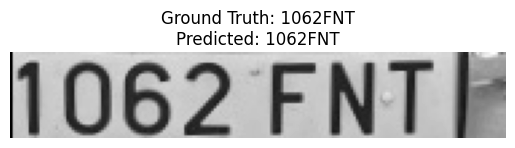

Processed Plate: 1062FNT (frontal) | Predicted: 1062FNT


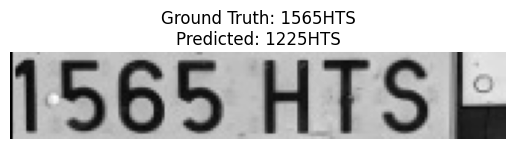

Processed Plate: 1565HTS (frontal) | Predicted: 1225HTS


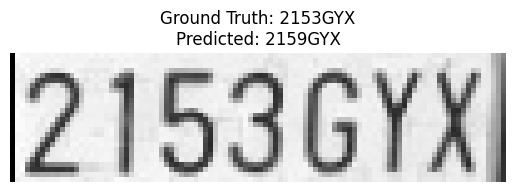

Processed Plate: 2153GYX (frontal) | Predicted: 2159GYX


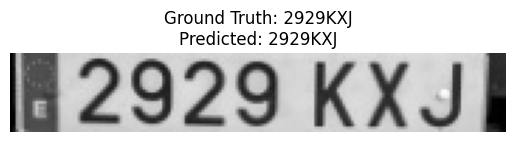

Processed Plate: 2929KXJ (frontal) | Predicted: 2929KXJ


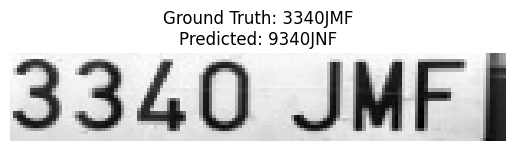

Processed Plate: 3340JMF (frontal) | Predicted: 9340JNF


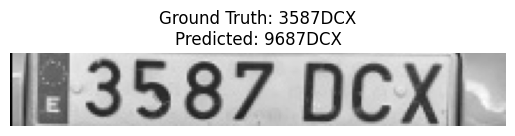

Processed Plate: 3587DCX (frontal) | Predicted: 9687DCX


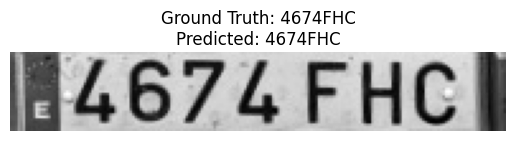

Processed Plate: 4674FHC (frontal) | Predicted: 4674FHC


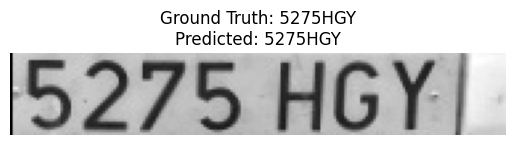

Processed Plate: 5275HGY (frontal) | Predicted: 5275HGY


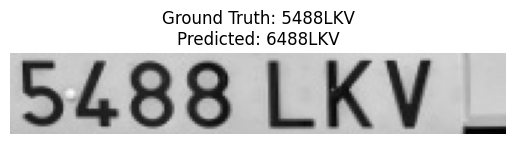

Processed Plate: 5488LKV (frontal) | Predicted: 6488LKV


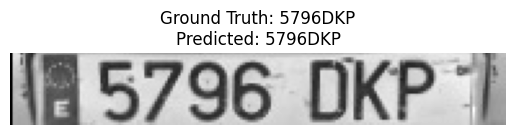

Processed Plate: 5796DKP (frontal) | Predicted: 5796DKP


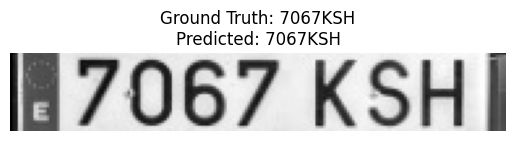

Processed Plate: 7067KSH (frontal) | Predicted: 7067KSH


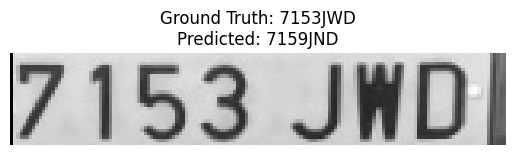

Processed Plate: 7153JWD (frontal) | Predicted: 7159JND


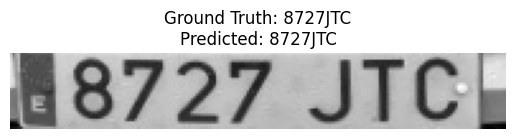

Processed Plate: 8727JTC (frontal) | Predicted: 8727JTC


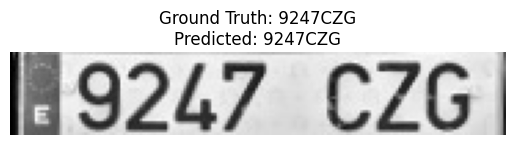

Processed Plate: 9247CZG (frontal) | Predicted: 9247CZG


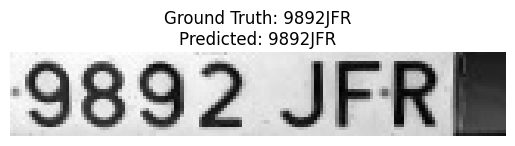

Processed Plate: 9892JFR (frontal) | Predicted: 9892JFR


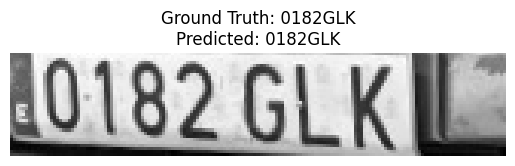

Processed Plate: 0182GLK (lateral) | Predicted: 0182GLK


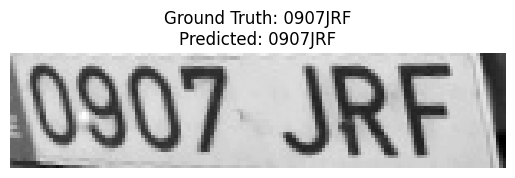

Processed Plate: 0907JRF (lateral) | Predicted: 0907JRF


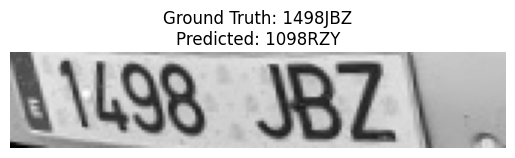

Processed Plate: 1498JBZ (lateral) | Predicted: 1098RZY


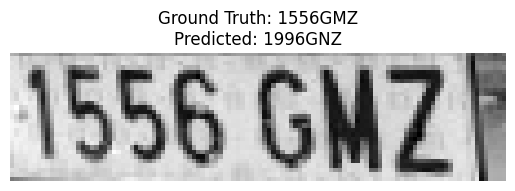

Processed Plate: 1556GMZ (lateral) | Predicted: 1996GNZ


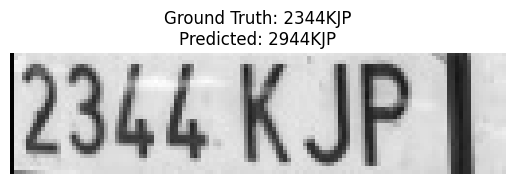

Processed Plate: 2344KJP (lateral) | Predicted: 2944KJP


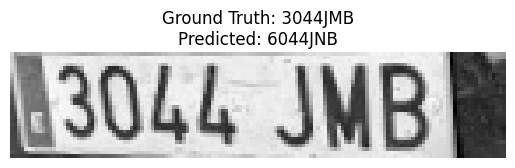

Processed Plate: 3044JMB (lateral) | Predicted: 6044JNB


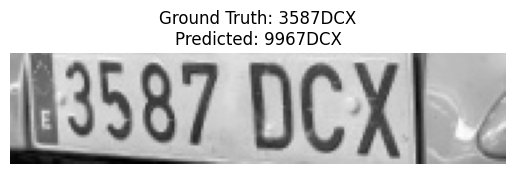

Processed Plate: 3587DCX (lateral) | Predicted: 9967DCX


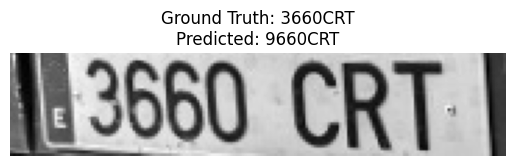

Processed Plate: 3660CRT (lateral) | Predicted: 9660CRT


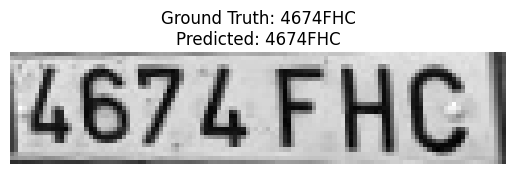

Processed Plate: 4674FHC (lateral) | Predicted: 4674FHC


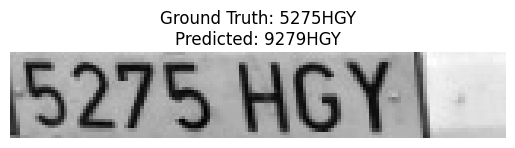

Processed Plate: 5275HGY (lateral) | Predicted: 9279HGY


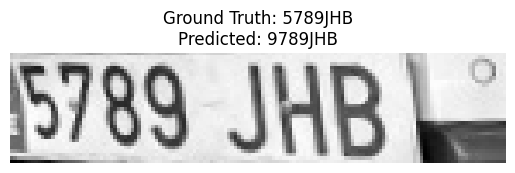

Processed Plate: 5789JHB (lateral) | Predicted: 9789JHB


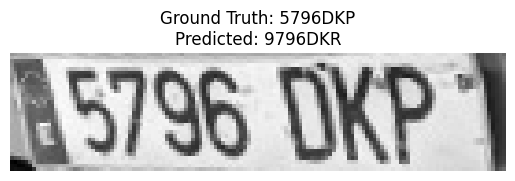

Processed Plate: 5796DKP (lateral) | Predicted: 9796DKR


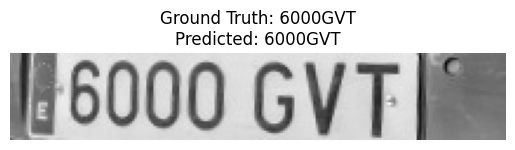

Processed Plate: 6000GVT (lateral) | Predicted: 6000GVT


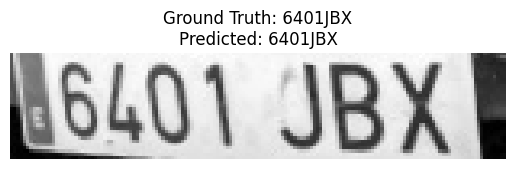

Processed Plate: 6401JBX (lateral) | Predicted: 6401JBX


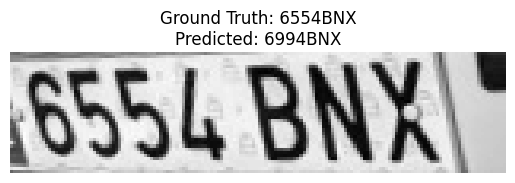

Processed Plate: 6554BNX (lateral) | Predicted: 6994BNX


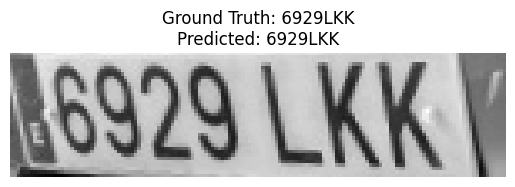

Processed Plate: 6929LKK (lateral) | Predicted: 6929LKK


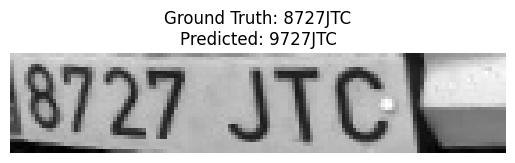

Processed Plate: 8727JTC (lateral) | Predicted: 9727JTC

Character-Level Accuracy: 85.71% (192 correct out of 224)


In [19]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Function definitions (as provided previously)
# ... (insert the functions defined in the previous response here) ...

#load the KNN models and label encoders
knn_model_numbers_path = 'knn_numbers_model.pkl'
knn_model_letters_path = 'knn_letters_model.pkl'
label_encoder_numbers_path = 'label_encoder_numbers.pkl'
label_encoder_letters_path = 'label_encoder_letters.pkl'

#load the KNN models
with open(knn_model_numbers_path, 'rb') as knn_file:
    knn_numbers_model = pickle.load(knn_file)

with open(knn_model_letters_path, 'rb') as knn_file:
    knn_letters_model = pickle.load(knn_file)

#load the label encoders
with open(label_encoder_numbers_path, 'rb') as encoder_file:
    label_encoder_numbers = pickle.load(encoder_file)

with open(label_encoder_letters_path, 'rb') as encoder_file:
    label_encoder_letters = pickle.load(encoder_file)

print("Models and Label Encoders loaded successfully.")

#set the paths to your dataset
plate_digits_folder = 'PlateDigits'
plate_images_folder = 'PlateImages'

# Call the function to process all plates
process_all_plates(
    plate_digits_folder, 
    plate_images_folder, 
    knn_numbers_model, 
    knn_letters_model, 
    label_encoder_numbers, 
    label_encoder_letters
)
